# MLP univariate

## Import library

In [75]:
# 1. IMPORT LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from statsmodels.graphics.tsaplots import plot_acf
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")

## Konfigurasi parameter
Mengatur seed untuk reproducibility dan mendefinisikan parameter utama untuk model dan proses training.

In [76]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Parameter utama
FILE_PATH = "bbri_2025.xlsx"
SHEET_NAME = 'Sheet1'
TARGET_COLUMN = 'Close'
LOOK_BACK = 2
TRAIN_SPLIT_RATIO = 0.8
EPOCHS = 100
BATCH_SIZE = 32
TUNER_MAX_TRIALS = 15
TUNER_EPOCHS = 100

In [77]:
def create_dataset_mlp(dataset, look_back=1):
    """
    Mengubah array nilai menjadi format dataset untuk MLP.
    Contoh:
    dataset = [1, 2, 3, 4, 5]
    look_back = 2
    Maka hasilnya:
    dataX = [[1, 2], [2, 3], [3, 4]]
    dataY = [3, 4, 5]
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # Ambil sequence [i] s/d [i+look_back] sebagai fitur
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        # Ambil data [i + look_back] sebagai target
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Persiapan data

In [78]:
from IPython.display import display, HTML

print(f"Memuat data dari {FILE_PATH} (Fitur: {TARGET_COLUMN})...")
df = pd.read_excel(
    FILE_PATH,
    sheet_name=SHEET_NAME,
    usecols=['Date', TARGET_COLUMN],
    parse_dates=['Date'],
    index_col='Date',
    engine='openpyxl'
)
df = df.dropna()

print("\nPreview Data:")
display(df.head())

dataset_values = df[TARGET_COLUMN].values.reshape(-1, 1).astype('float32')

Memuat data dari bbri_2025.xlsx (Fitur: Close)...

Preview Data:


,Close
Date,
2025-01-02,4210
2025-01-03,4150
2025-01-06,4100
2025-01-07,4030
2025-01-08,4080


<Figure size 1000x600 with 0 Axes>

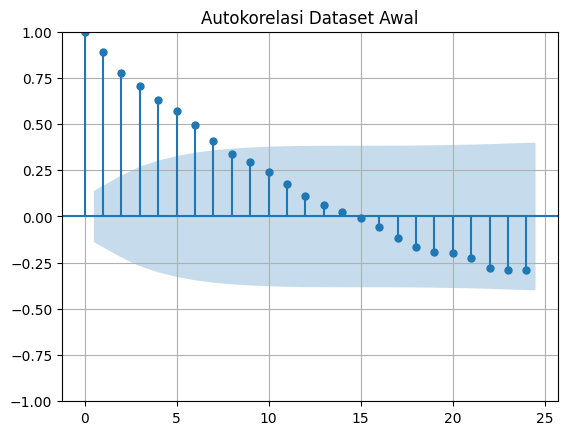

In [79]:
plt.figure(figsize=(10,6))
plot_acf(dataset_values, alpha=0.05)
plt.title('Autokorelasi Dataset Awal')
plt.grid(True)
plt.show()

### Preprocessing 
Split dataset menjadi train dan test, lakukan normalisasi, dan transformasi ke format supervised learning.

In [80]:
# Split dataset sebelum scaling
train_size = int(len(dataset_values) * TRAIN_SPLIT_RATIO)
train_values = dataset_values[:train_size]
test_values  = dataset_values[train_size:]

# Fit scaler hanya pada data training
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_values)
scaled_train = scaler.transform(train_values)
scaled_test  = scaler.transform(test_values)

# Buat dataset MLP
X_train, y_train = create_dataset_mlp(scaled_train, LOOK_BACK)
X_test, y_test   = create_dataset_mlp(scaled_test, LOOK_BACK)

print(f"Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape X_train: (158, 2), y_train: (158,)
Shape X_test: (39, 2), y_test: (39,)


## Pemodelan

### Definisi Arsitektur Model

In [81]:
def build_model(hp):
    model = Sequential()
    hp_units = hp.Int('units_layer1', min_value=32, max_value=256, step=32)
    hp_layers = hp.Int('num_layers', min_value=1, max_value=3)
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(Dense(hp_units, activation='relu', input_dim=LOOK_BACK))
    for i in range(hp_layers - 1):
        hp_units_hidden = hp.Int(f'units_layer_{i+2}', min_value=32, max_value=128, step=32)
        model.add(Dense(hp_units_hidden, activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

### Hyperparameter tunning
Pencarian hyperparameter terbaik menggunakan Keras Tuner dengan metode Random Search.

In [82]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=TUNER_MAX_TRIALS,
    executions_per_trial=1,
    directory='kt_tuning_dir_mlp_uni',
    project_name='bbri_forecasting_mlp_uni'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nMulai Hyperparameter Tuning (MLP Univariate)...")
tuner.search(
    X_train, y_train,
    epochs=TUNER_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"\n--- HYPERPARAMETER TERBAIK ---")
print(f"Learning Rate  : {best_hps.get('learning_rate')}")
print(f"Num Layers     : {best_hps.get('num_layers')}")
print(f"Units Layer 1  : {best_hps.get('units_layer1')}")
print("------------------------------------------")

Trial 15 Complete [00h 00m 20s]
val_loss: 0.007221392821520567

Best val_loss So Far: 0.006457898765802383
Total elapsed time: 00h 09m 55s

--- HYPERPARAMETER TERBAIK ---
Learning Rate  : 0.01
Num Layers     : 2
Units Layer 1  : 224
------------------------------------------


### Training model final
Membangun dan melatih model dengan hyperparameter terbaik

In [83]:
print("\nMembangun model final dengan hyperparameter terbaik...")
model = build_model(best_hps)
model.summary()

early_stopping_final = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print(f"\nMulai training model FINAL (Epochs={EPOCHS}, Batch Size={BATCH_SIZE})...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    callbacks=[early_stopping_final],
    shuffle=False,
    verbose=1
)
print("Training final selesai.")


Membangun model final dengan hyperparameter terbaik...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 224)            │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)


Mulai training model FINAL (Epochs=100, Batch Size=32)...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1339 - mae: 0.2682 - val_loss: 0.0264 - val_mae: 0.1421
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0180 - mae: 0.1045 - val_loss: 0.0087 - val_mae: 0.0756
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0110 - mae: 0.0791 - val_loss: 0.0159 - val_mae: 0.1020
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0115 - mae: 0.0839 - val_loss: 0.0071 - val_mae: 0.0665
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0102 - mae: 0.0774 - val_loss: 0.0100 - val_mae: 0.0761
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0092 - mae: 0.0721 - val_loss: 0.0079 - val_mae: 0.0670
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0094 - mae: 0.0731 - val_loss: 0.0076 - val_mae: 0.0661
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0086 - mae: 0.0676 - val_loss: 0.0085 - val_mae: 0.0675
Epoch 9/100
5

### Visualisasi loss training

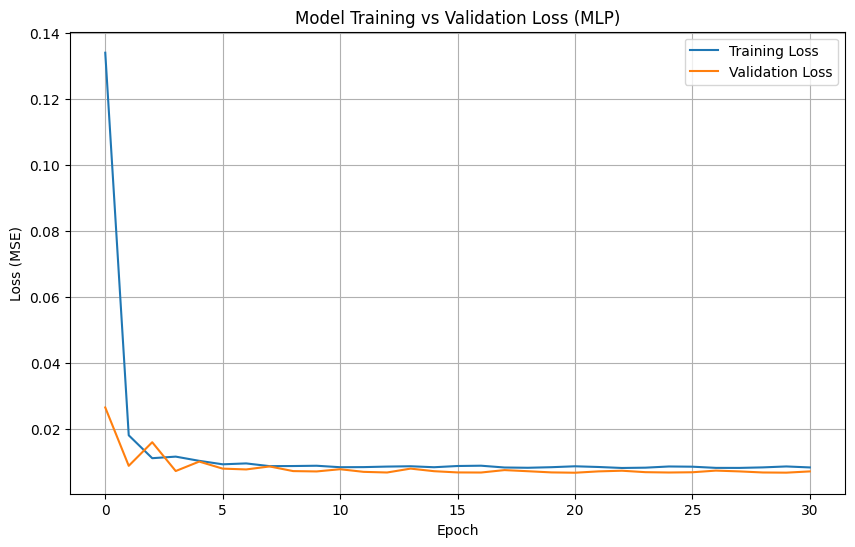

In [84]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training vs Validation Loss (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi model

### Prediksi dan invers transform

In [85]:
# Prediksi
train_predict = model.predict(X_train)
test_predict  = model.predict(X_test)

# Kembalikan ke skala asli
train_predict_orig = scaler.inverse_transform(train_predict)
test_predict_orig  = scaler.inverse_transform(test_predict)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig  = scaler.inverse_transform(y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


### Metrik evaluasi
Perhitungan RMSE, MAE, dan MAPE untuk mengukur akurasi model.

In [86]:
train_rmse = math.sqrt(mean_squared_error(y_train_orig, train_predict_orig))
test_rmse = math.sqrt(mean_squared_error(y_test_orig, test_predict_orig))
train_mae = mean_absolute_error(y_train_orig, train_predict_orig)
test_mae = mean_absolute_error(y_test_orig, test_predict_orig)

epsilon = 1e-10
train_mape = np.mean(np.abs((y_train_orig - train_predict_orig) / (y_train_orig + epsilon))) * 100
test_mape = np.mean(np.abs((y_test_orig - test_predict_orig) / (y_test_orig + epsilon))) * 100

print(f"\n--- HASIL EVALUASI ---")
print(f"Train RMSE : {train_rmse:.2f}")
print(f"Test  RMSE : {test_rmse:.2f}")
print(f"Train MAE  : {train_mae:.2f}")
print(f"Test  MAE  : {test_mae:.2f}")
print(f"Train MAPE : {train_mape:.2f}%")
print(f"Test  MAPE : {test_mape:.2f}%")


--- HASIL EVALUASI ---
Train RMSE : 96.17
Test  RMSE : 75.97
Train MAE  : 71.35
Test  MAE  : 60.02
Train MAPE : 1.83%
Test  MAPE : 1.58%


### Visualisasi hasil prediksi

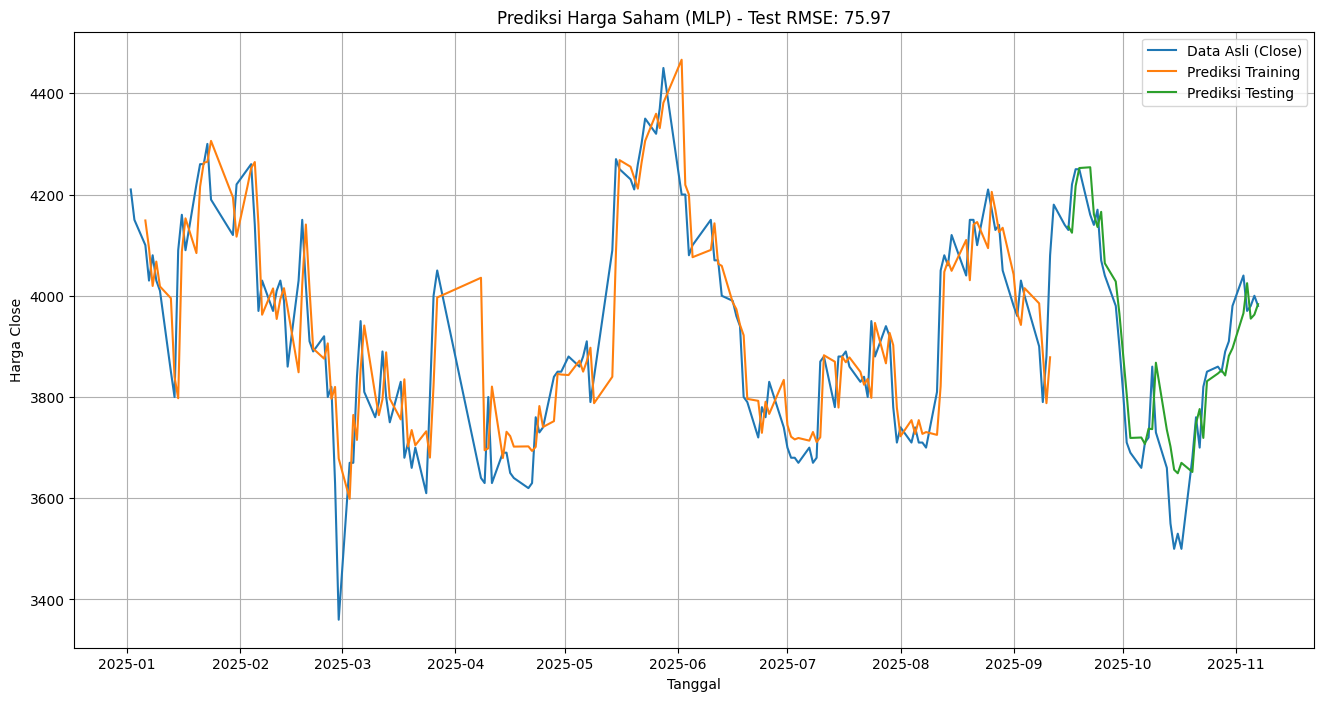

In [ ]:
# Array kosong skala asli
full_true = dataset_values.copy()
train_plot = np.empty_like(full_true)
train_plot[:] = np.nan
test_plot = np.empty_like(full_true)
test_plot[:] = np.nan

# Posisi untuk training dan testing
train_plot[LOOK_BACK:LOOK_BACK+len(train_predict_orig), 0] = train_predict_orig.flatten()
test_start = train_size + LOOK_BACK
test_plot[test_start:test_start+len(test_predict_orig), 0] = test_predict_orig.flatten()

plt.figure(figsize=(16,8))
plt.plot(df.index, full_true, label='Data Asli (Close)')
plt.plot(df.index, train_plot, label='Prediksi Training')
plt.plot(df.index, test_plot, label='Prediksi Testing')
plt.title(f'Prediksi Harga Saham (MLP) - Test RMSE: {test_rmse:.2f}')
plt.xlabel('Tanggal')
plt.ylabel('Harga Close')
plt.legend()
plt.grid(True)
plt.show()

### Autokorelasi residu

<Figure size 1000x600 with 0 Axes>

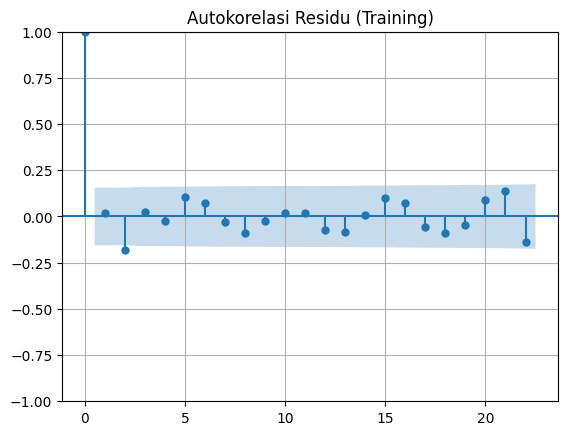

<Figure size 1000x600 with 0 Axes>

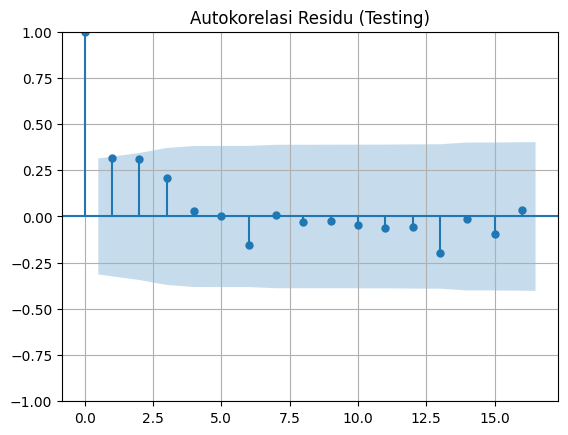

In [88]:
train_residuals = y_train_orig.flatten() - train_predict_orig.flatten()
test_residuals = y_test_orig.flatten() - test_predict_orig.flatten()

plt.figure(figsize=(10,6))
plot_acf(train_residuals, alpha=0.05)
plt.title('Autokorelasi Residu (Training)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plot_acf(test_residuals, alpha=0.05)
plt.title('Autokorelasi Residu (Testing)')
plt.grid(True)
plt.show()